In [282]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import os
import json
from tqdm import tqdm
from data import load_ff3, load_ff6
from models import SimpleFeedForwardNN, SimpleLSTM
from xgboost import XGBRegressor
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

In [283]:
RANGES = {
    "bullish": [
        (1980, 1980),
        (
            1982,
            1986,
        ),  # After the recession in the early 1980s, the market entered a bullish phase, culminating in the 1987 peak before the crash.
        (1988, 1989),  # Russian default on debt
        (
            1991,
            1999,
        ),  # This period, often referred to as the "Dot-com Bubble," was a significant bull market driven by rapid growth in technology stocks.
        (
            2003,
            2007,
        ),  # The market experienced a significant bull run during this period, driven by strong economic growth and low interest rates.
        (
            2009,
            2017,
        ),  # The market recovered from the 2008 financial crisis and entered a long bull market, driven by low interest rates and economic growth.
        (2019, 2019),
        (
            2021,
            2021,
        ),  # The market recovered from the COVID-19 pandemic and entered a bull market, driven by low interest rates and economic recovery.
        (
            2023,
            2023,
        ),  # The market recovered from the COVID-19 pandemic and entered a bull market, driven by low interest rates and economic recovery.
    ],
    "bearish": [
        (
            1981,
            1981,
        ),  # The early 1980s recession was a significant bear market, culminating in the 1982 market bottom. High inflation and interest rates drove the downturn.
        (1987, 1987),  # Black Monday
        (
            1990,
            1990,
        ),  # The early 1990s recession was a significant bear market, driven by the Gulf War and economic slowdown.
        (
            2000,
            2002,
        ),  # The early 2000s recession was a significant bear market, driven by the bursting of the Dot-com Bubble and economic slowdown.
        (
            2008,
            2008,
        ),  # The 2008 financial crisis was a significant bear market, driven by the subprime mortgage crisis and financial system collapse.
        (
            2018,
            2018,
        ),  # Donald Trump's trade war with China, the slowdown in global economic growth and concern that the Federal Reserve was raising interest rates too quickly
        (
            2020,
            2020,
        ),  # The COVID-19 pandemic led to a significant bear market in 2020, driven by economic shutdowns and uncertainty.
        (
            2022,
            2022,
        ),  # The market experienced a significant bear market in 2022, driven by concerns about inflation and interest rates.
    ],
}


def is_bullish_or_bearish(curr_year):
    for key, value in RANGES.items():
        for start, end in value:
            if curr_year >= start and curr_year <= end:
                return key
    return None

In [284]:
def calc_sharpe(excess_returns, rf_ret):
    excess_returns = excess_returns.resample('M').apply(lambda x: (x/100 + 1).prod() - 1)
    rf_ret = rf_ret.resample('M').apply(lambda x: (x/100 + 1).prod() - 1)
    
    sharpe = (excess_returns / (excess_returns + rf_ret).std()).mean()
    return sharpe

def benchmark_analysis(excess_returns, benchmark_excess_returns, rf_ret, print_summary=True):
    y_ols = sm.add_constant(benchmark_excess_returns)
    model_OLS = sm.OLS(excess_returns, y_ols).fit()
    
    alpha = model_OLS.params['const']
    alpha_annual = (np.power(1 + alpha / 100, 22 * 12) - 1) * 100
    beta = model_OLS.params['Mkt-RF']
    alpha_p = model_OLS.pvalues['const']
    sharpe = calc_sharpe(excess_returns, rf_ret)
    
    if print_summary:
        print(f"Alpha: {alpha:.4f}% ({alpha_annual:.4f}% annualized)")
        print(f"Beta: {beta:.4f}")
        print(f"Alpha p-value: {alpha_p:.4f}")
        print(f"Sharpe ratio: {sharpe:.4f}")
    
    return {'alpha': alpha, 'alpha_annual': alpha_annual, 'beta': beta, 'alpha_p': alpha_p, 'sharpe': sharpe}

def analyze_yearrange(strat_ret_vec, start_year, end_year, benchmark_type="FF6", print_summary=True):
    strat_ret_vec = strat_ret_vec.copy()
    
    start_date = f"{start_year}0101"
    end_date = f"{end_year}0101"
    
    val_start_idx = strat_ret_vec[strat_ret_vec['date'] >= int(start_date)].index[0]
    try:
        val_end_idx = strat_ret_vec[strat_ret_vec['date'] >= int(end_date)].index[0]
    except IndexError:
        val_end_idx = len(strat_ret_vec)
    
    strat_ret_vec = strat_ret_vec.iloc[val_start_idx:val_end_idx]
    ff6_daily = load_ff6(val_start_date=start_date, val_end_date=end_date)
    ff6_daily.index = pd.to_datetime(ff6_daily.index, format='%Y%m%d')
    
    bullish_returns = pd.DataFrame(columns=['daily_ret'])
    bearish_returns = pd.DataFrame(columns=['daily_ret'])
    
    mkt_bullish_returns = pd.DataFrame(columns=['daily_ret'])
    mkt_bearish_returns = pd.DataFrame(columns=['daily_ret'])
    
    strat_ret_vec_datetime = strat_ret_vec.copy()
    strat_ret_vec_datetime['date'] = pd.to_datetime(strat_ret_vec_datetime['date'], format='%Y%m%d')
    strat_ret_vec_datetime.set_index('date', inplace=True)
    
    for year in range(start_year, end_year):
        year_strat_ret_vec = strat_ret_vec_datetime[strat_ret_vec_datetime.index.year == year]
        year_mkt_ret_vec = ff6_daily[ff6_daily.index.year == year]
        
        bullish_or_bearish = is_bullish_or_bearish(year)
        if bullish_or_bearish == 'bullish':
            bullish_returns = pd.concat([bullish_returns, year_strat_ret_vec], axis=0)
            mkt_bullish_returns = pd.concat([mkt_bullish_returns, year_mkt_ret_vec], axis=0)            
        elif bullish_or_bearish == 'bearish':
            bearish_returns = pd.concat([bearish_returns, year_strat_ret_vec], axis=0)
            mkt_bearish_returns = pd.concat([mkt_bearish_returns, year_mkt_ret_vec], axis=0)
    
    strat_ret_vec = strat_ret_vec.drop(columns=['date'])
    strat_ret_vec.index = ff6_daily.index
    
    total_ff6 = ff6_daily
    bullish_ff6 = mkt_bullish_returns
    bearish_ff6 = mkt_bearish_returns
    
    total_excess_ret = strat_ret_vec['daily_ret'] - total_ff6['RF']
    bullish_excess_ret = bullish_returns['daily_ret'] - bullish_ff6['RF']
    bearish_excess_ret = bearish_returns['daily_ret'] - bearish_ff6['RF']
    
    factor_cols = []
    if benchmark_type == "CAPM":
        factor_cols = ['Mkt-RF']
    elif benchmark_type == "FF3":
        factor_cols = ['Mkt-RF', 'SMB', 'HML']
    elif benchmark_type == "FF6":
        factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
    
    total_analysis = benchmark_analysis(
        total_excess_ret, 
        total_ff6[factor_cols], 
        rf_ret=total_ff6['RF'],
        print_summary=False
    )
    
    bullish_analysis = benchmark_analysis(
        bullish_excess_ret, 
        bullish_ff6[factor_cols], 
        rf_ret=bullish_ff6['RF'],
        print_summary=False
    )
    
    bearish_analysis = benchmark_analysis(
        bearish_excess_ret, 
        bearish_ff6[factor_cols], 
        rf_ret=bearish_ff6['RF'],
        print_summary=False
    )
    
    total_rets = strat_ret_vec
    total_mkt_rets = total_ff6['Mkt-RF'] + total_ff6['RF']
    
    total_cum_rets = (strat_ret_vec / 100 + 1).cumprod()
    total_cum_rets.index = pd.to_datetime(total_cum_rets.index, format="%Y%m%d")
    total_cum_rets_monthly = total_cum_rets.resample('M').last()
    
    total_mkt_cum_rets = ((total_ff6['Mkt-RF'] + total_ff6['RF']) / 100 + 1).cumprod()
    total_mkt_cum_rets.index = pd.to_datetime(total_mkt_cum_rets.index, format="%Y%m%d")
    total_mkt_cum_rets_monthly = total_mkt_cum_rets.resample('M').last()
    
    
    if print_summary:
        print(f"Total {benchmark_type} Analysis from {start_year} to {end_year}:")
        print(f"\tAlpha: {total_analysis['alpha']:.4f}% ({total_analysis['alpha_annual']:.4f}% annualized)")
        print(f"\tBeta: {total_analysis['beta']:.4f}")
        print(f"\tAlpha p-value: {total_analysis['alpha_p']:.4f}")
        print(f"\tSharpe ratio: {total_analysis['sharpe']:.4f}\n\n")
        
        print(f"Bullish {benchmark_type} Analysis from {start_year} to {end_year}:")
        print(f"\tAlpha: {bullish_analysis['alpha']:.4f}% ({bullish_analysis['alpha_annual']:.4f}% annualized)")
        print(f"\tBeta: {bullish_analysis['beta']:.4f}")
        print(f"\tAlpha p-value: {bullish_analysis['alpha_p']:.4f}")
        print(f"\tSharpe ratio: {bullish_analysis['sharpe']:.4f}\n\n")
        
        print(f"Bearish {benchmark_type} Analysis from {start_year} to {end_year}:")
        print(f"\tAlpha: {bearish_analysis['alpha']:.4f}% ({bearish_analysis['alpha_annual']:.4f}% annualized)")
        print(f"\tBeta: {bearish_analysis['beta']:.4f}")
        print(f"\tAlpha p-value: {bearish_analysis['alpha_p']:.4f}")
        print(f"\tSharpe ratio: {bearish_analysis['sharpe']:.4f}\n\n")
    
    return total_analysis, bullish_analysis, bearish_analysis, total_cum_rets_monthly, total_mkt_cum_rets_monthly, total_rets, total_mkt_rets

In [285]:
# _, _, _, lstm_cum_rets, mkt_cum_rets, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], 1980, 2024, print_summary=True)

In [286]:
H_config = {
    'seq_len': 5,
    'num_industries': 49,
    'strat': 'max-min_LS',
}

H_lstm_dir = f"results/{H_config['seq_len']}seq_len/SimpleLSTM/{H_config['num_industries']}industries/value/5epochs/{H_config['strat']}"

H_ffnn_dir = f"results/{H_config['seq_len']}seq_len/SimpleFeedForwardNN/{H_config['num_industries']}industries/value/5epochs/{H_config['strat']}"

H_xgb_dir = f"results/{H_config['seq_len']}seq_len/XGBRegressor/{H_config['num_industries']}industries/value/{H_config['strat']}"

In [287]:
strat_ret_vecs = {}

for dir_ in [H_lstm_dir, H_ffnn_dir, H_xgb_dir]:
    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    strat_ret_vecs[dir_] = strat_ret_vec

## Plots

### PLOT 1 - Best Model vs. Other Models

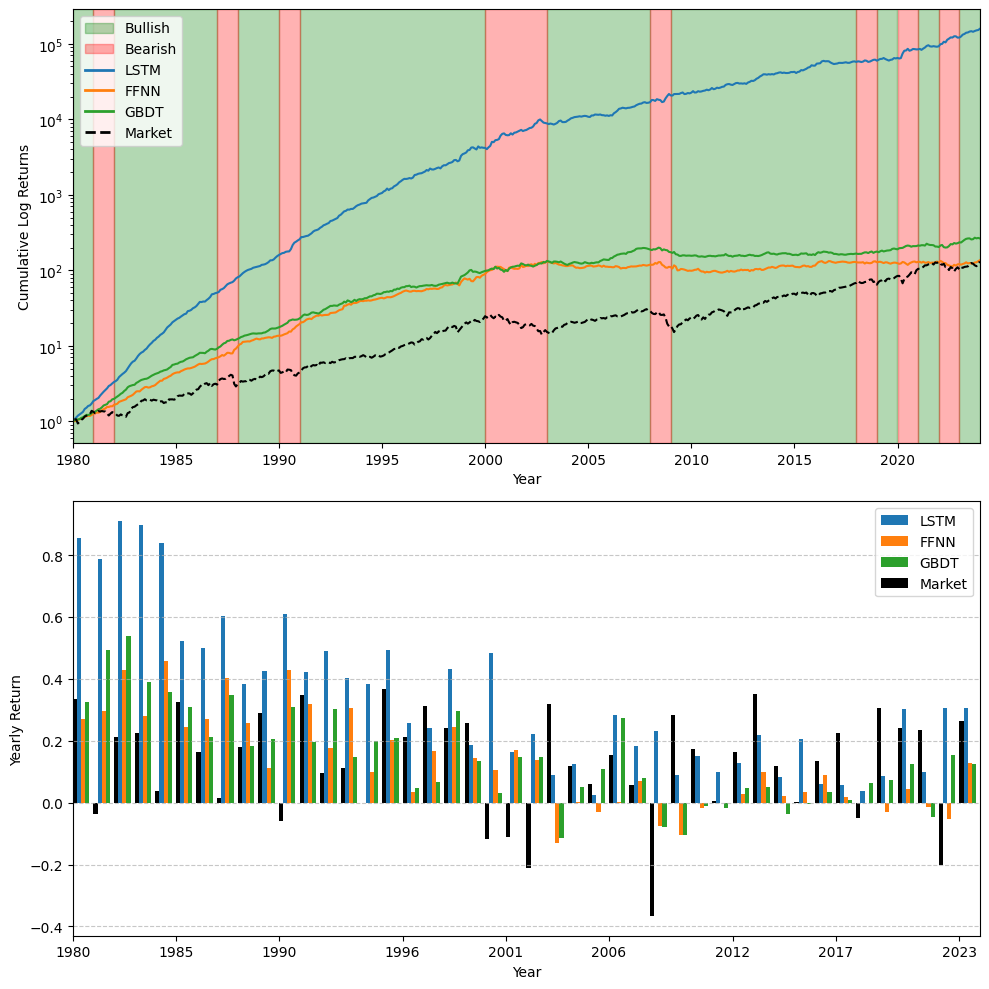

In [288]:
### PLOT 1

# Assuming `analyze_yearrange` and `strat_ret_vecs` are defined elsewhere
_, _, _, lstm_cum_rets, mkt_cum_rets, lstm_rets, mkt_rets = analyze_yearrange(strat_ret_vecs[H_lstm_dir], 1980, 2024, print_summary=False)
_, _, _, ffnn_cum_rets, _, ffnn_rets, _ = analyze_yearrange(strat_ret_vecs[H_ffnn_dir], 1980, 2024, print_summary=False)
_, _, _, xgb_cum_rets, _, xgb_rets, _ = analyze_yearrange(strat_ret_vecs[H_xgb_dir], 1980, 2024, print_summary=False)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

ax0 = axs[0]
ax1 = axs[1]

# Custom legend handles for the colored regions
bullish_patch = mpatches.Patch(color='green', alpha=0.3, label='Bullish')
bearish_patch = mpatches.Patch(color='red', alpha=0.3, label='Bearish')

for status, year_range in RANGES.items():
    color = "green" if status == "bullish" else "red"
    for start, end in year_range:
        start_t = pd.to_datetime(f"{start}0101", format="%Y%m%d")
        end_t = pd.to_datetime(f"{end}1231", format="%Y%m%d")
        ax0.axvspan(start_t, end_t, color=color, alpha=0.3)

ax0.plot(lstm_cum_rets, label='LSTM')
ax0.plot(ffnn_cum_rets, label='FFNN')
ax0.plot(xgb_cum_rets, label='GBDT')
ax0.plot(mkt_cum_rets, label='Market', color='black', linestyle='--')
ax0.set_yscale('log')
ax0.set_xlabel('Year')
ax0.set_ylabel('Cumulative Log Returns')
# ax0.legend()

ax0.legend(handles=[bullish_patch, bearish_patch, 
                    plt.Line2D([0], [0], color='C0', lw=2, label='LSTM'), 
                    plt.Line2D([0], [0], color='C1', lw=2, label='FFNN'), 
                    plt.Line2D([0], [0], color='C2', lw=2, label='GBDT'),
                    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Market')], loc='upper left')

# ax0.set_title("Model Comparison on Best Configuration")
ax0.set_xlim(pd.to_datetime("1980-01-01"), pd.to_datetime("2024-01-01"))


barwidth = 0.2

mkt_ret_vec_monthly = mkt_rets.copy()
mkt_ret_vec_monthly.index = pd.to_datetime(mkt_ret_vec_monthly.index, format="%Y%m%d")
mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)

x = np.arange(len(mkt_ret_vec_monthly.index))

i = 1
for strat_rets, name in zip([lstm_rets, ffnn_rets, xgb_rets], ['LSTM', 'FFNN', 'GBDT']):
    strat_ret_vec_monthly = strat_rets.copy()
    strat_ret_vec_monthly.index = pd.to_datetime(strat_ret_vec_monthly.index, format="%Y%m%d")
    strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)

    # ax1.bar(x - 2 * barwidth + i * (barwidth), strat_ret_vec_monthly['daily_ret'], label=name, width=barwidth)
    ax1.bar(x + barwidth/2 + i * (barwidth), strat_ret_vec_monthly['daily_ret'], label=name, width=barwidth)

    i += 1
    
# ax1.bar(x - 2 * barwidth, mkt_ret_vec_monthly.values, label="Market", width=barwidth, color='black')
ax1.bar(x + barwidth/2, mkt_ret_vec_monthly.values, label="Market", width=barwidth, color='black')

num_ticks = len(ax0.get_xticks()) - 1
tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
tick_labels = strat_ret_vec_monthly.index[tick_positions].strftime('%Y')
    

ax1.set_xlabel("Year")
ax1.set_ylabel("Yearly Return")
ax1.legend(loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)
ax1.set_xlim(0, len(x))

plt.tight_layout()
plt.savefig("2024_plot1_model_comparison.png")
plt.show()

### Plot 2 - Best Model Split Across Time

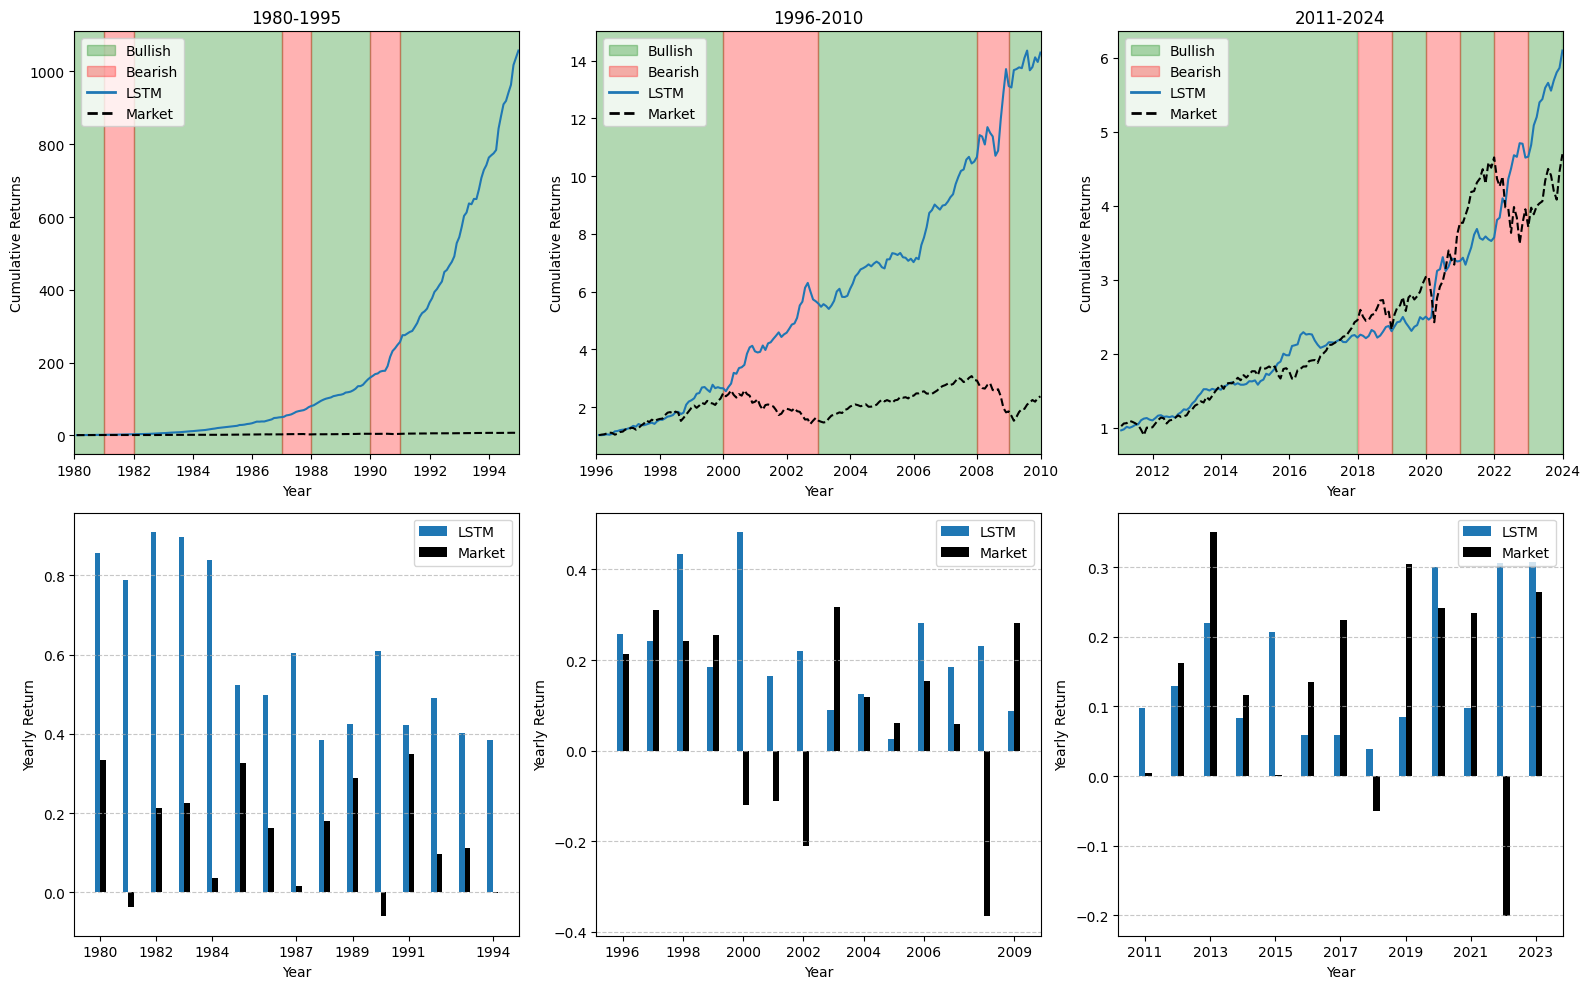

In [289]:
### PLOT 2 

ANALYZE_TIMERANGES = [
    (1980, 1995),
    (1996, 2010),
    (2011, 2024),
]


fig, axs = plt.subplots(2, 3, figsize=(16, 10))

_, _, _, lstm_cum_rets_0, mkt_cum_rets_0, lstm_rets_0, mkt_rets_0 = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
_, _, _, lstm_cum_rets_1, mkt_cum_rets_1, lstm_rets_1, mkt_rets_1 = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1],  print_summary=False)
_, _, _, lstm_cum_rets_2, mkt_cum_rets_2, lstm_rets_2, mkt_rets_2 = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1],  print_summary=False)

i = 0
for strat_cum_rets, mkt_cum_rets in zip([lstm_cum_rets_0, lstm_cum_rets_1, lstm_cum_rets_2], [mkt_cum_rets_0, mkt_cum_rets_1, mkt_cum_rets_2]):
    ax = axs[0, i]
    ax.plot(strat_cum_rets, label='LSTM')
    ax.plot(mkt_cum_rets, label='Market', color='black', linestyle='--')
    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative Returns')
    ax.set_xlim(pd.to_datetime(f"{ANALYZE_TIMERANGES[i][0]}-01-01"), pd.to_datetime(f"{ANALYZE_TIMERANGES[i][1]}-01-01"))
    ax.set_title(f"{ANALYZE_TIMERANGES[i][0]}-{ANALYZE_TIMERANGES[i][1]}")

    # Custom legend handles for the colored regions
    bullish_patch = mpatches.Patch(color='green', alpha=0.3, label='Bullish')
    bearish_patch = mpatches.Patch(color='red', alpha=0.3, label='Bearish')

    for status, year_range in RANGES.items():
        color = "green" if status == "bullish" else "red"
        for start, end in year_range:
            start_t = pd.to_datetime(f"{start}0101", format="%Y%m%d")
            end_t = pd.to_datetime(f"{end}1231", format="%Y%m%d")
            ax.axvspan(start_t, end_t, color=color, alpha=0.3)

    i += 1

i = 0
for strat_rets, mkt_rets in zip([lstm_rets_0, lstm_rets_1, lstm_rets_2], [mkt_rets_0, mkt_rets_1, mkt_rets_2]):
    ax = axs[1, i]
    
    strat_ret_vec_monthly = strat_rets.copy()
    strat_ret_vec_monthly.index = pd.to_datetime(strat_ret_vec_monthly.index, format="%Y%m%d")
    strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)

    mkt_ret_vec_monthly = mkt_rets.copy()
    mkt_ret_vec_monthly.index = pd.to_datetime(mkt_ret_vec_monthly.index, format="%Y%m%d")
    mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)

    x = np.arange(len(strat_ret_vec_monthly.index))

    num_ticks = 7
    tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
    tick_labels = strat_ret_vec_monthly.index[tick_positions].strftime('%Y')

    barwidth = 0.2
    
    ax.bar(x - barwidth/2, strat_ret_vec_monthly['daily_ret'], label="LSTM", width=barwidth )
    ax.bar(x + barwidth/2, mkt_ret_vec_monthly.values, label="Market", width=barwidth, color='black')
    ax.set_xlabel("Year")
    ax.set_ylabel("Yearly Return")
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    
    i += 1

for i in range(3):
    axs[0, i].legend(handles=[bullish_patch, bearish_patch, 
                              plt.Line2D([0], [0], color='C0', lw=2, label='LSTM'), 
                              plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Market')])

# fig.suptitle("Best Model's Backtest on Different Time Periods", fontsize=25)
plt.tight_layout()
plt.savefig("2024_plot2_model_comparison_timeperiods.png")
plt.show()

### PLOT 3 - not using

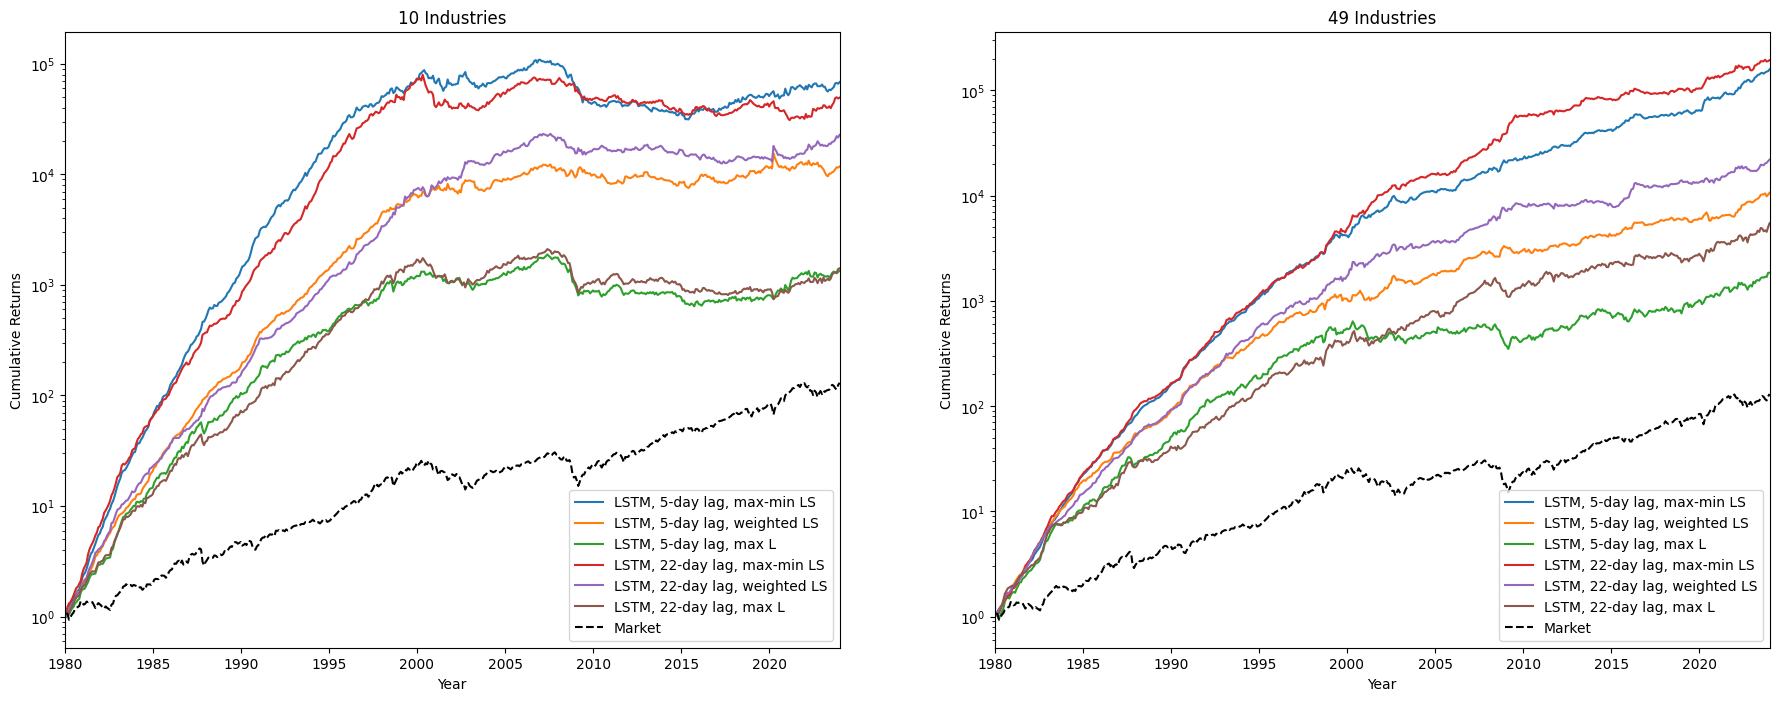

In [290]:
### PLOT 3

ind10_cum_rets = {}
ind49_cum_rets = {}

for num_industries in [10, 49]:
    for seq_len in [5, 22]:
        for strat in ['max-min_LS', 'weighted_LS', 'max_L']:
            dir_ = f"results/{seq_len}seq_len/SimpleLSTM/{num_industries}industries/value/5epochs/{strat}"
            strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
            strat_ret_vec = pd.read_csv(strat_ret_vec_path)
            strat_ret_vec['daily_ret'] = strat_ret_vec['0']
            strat_ret_vec = strat_ret_vec.drop(columns=['0'])
            
            _, _, _, cum_rets, mkt_cum_rets, _, _ = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
            
            ind10_cum_rets['Market'] = mkt_cum_rets
            ind49_cum_rets['Market'] = mkt_cum_rets
            
            key = f"LSTM, {seq_len}-day lag, {strat.replace('_', ' ')}"
            if num_industries == 10:
                ind10_cum_rets[key] = cum_rets
            else:
                ind49_cum_rets[key] = cum_rets
                
fig, axs = plt.subplots(1, 2, figsize=(22, 8))

for ax, cum_rets, title in zip([axs[0], axs[1]], [ind10_cum_rets, ind49_cum_rets], ["10 Industries", "49 Industries"]):
    for key, rets in cum_rets.items():
        if key != 'Market':
            ax.plot(rets, label=key)
    ax.plot(cum_rets['Market'], label='Market', color='black', linestyle='--')
    ax.set_yscale('log')
    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative Returns')
    ax.set_xlim(pd.to_datetime("1980-01-01"), pd.to_datetime("2024-01-01"))
    ax.set_title(title)
    ax.legend(loc='lower right')

### PLOT 3 - Best Model vs Industries

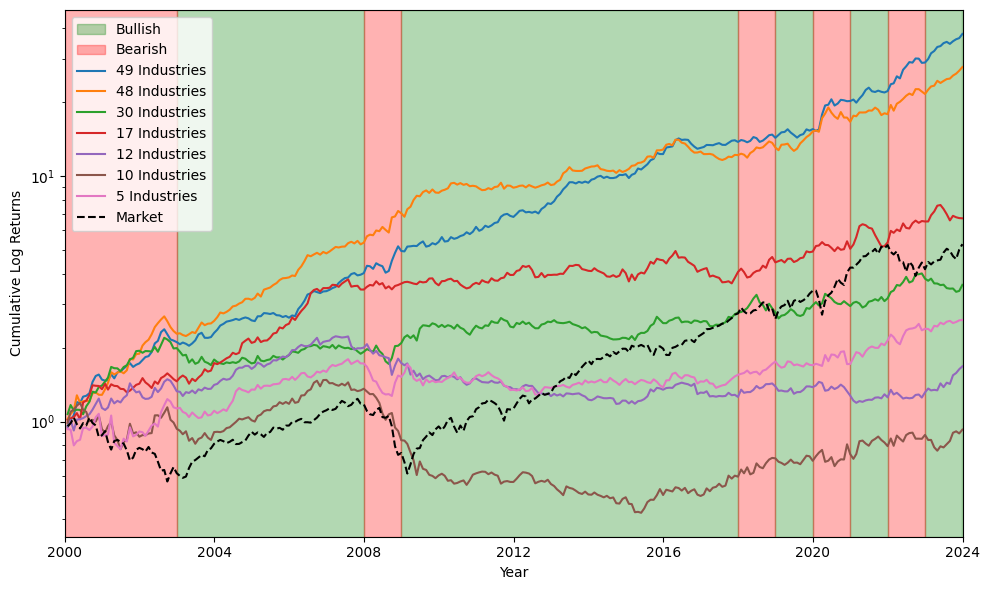

In [291]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

ax0 = axs

for num_industries in [5, 10, 12, 17, 30, 48, 49][::-1]:
    dir_ = f"results/5seq_len/SimpleLSTM/{num_industries}industries/value/5epochs/max-min_LS"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, _, _ = analyze_yearrange(strat_ret_vec, 2000, 2024, print_summary=False)

    ax0.plot(cum_rets, label=f"{num_industries} Industries")

bullish_patch = mpatches.Patch(color='green', alpha=0.3, label='Bullish')
bearish_patch = mpatches.Patch(color='red', alpha=0.3, label='Bearish')

for status, year_range in RANGES.items():
    color = "green" if status == "bullish" else "red"
    for start, end in year_range:
        start_t = pd.to_datetime(f"{start}0101", format="%Y%m%d")
        end_t = pd.to_datetime(f"{end}1231", format="%Y%m%d")
        plt.axvspan(start_t, end_t, color=color, alpha=0.3)

ax0.plot(mkt_cum_rets, label='Market', color='black', linestyle='--')
ax0.set_yscale('log')
ax0.set_xlabel('Year')
ax0.set_ylabel('Cumulative Log Returns')
ax0.legend(handles=[bullish_patch, bearish_patch] + plt.gca().get_legend_handles_labels()[0])
# ax0.set_title("Number of Industries Comparison on Best Configuration")
ax0.set_xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2024-01-01"))

plt.tight_layout()
plt.savefig("2024_plot3_num_industries_comparison.png")
plt.show()


### Plot 4 - Best Model vs. Lags

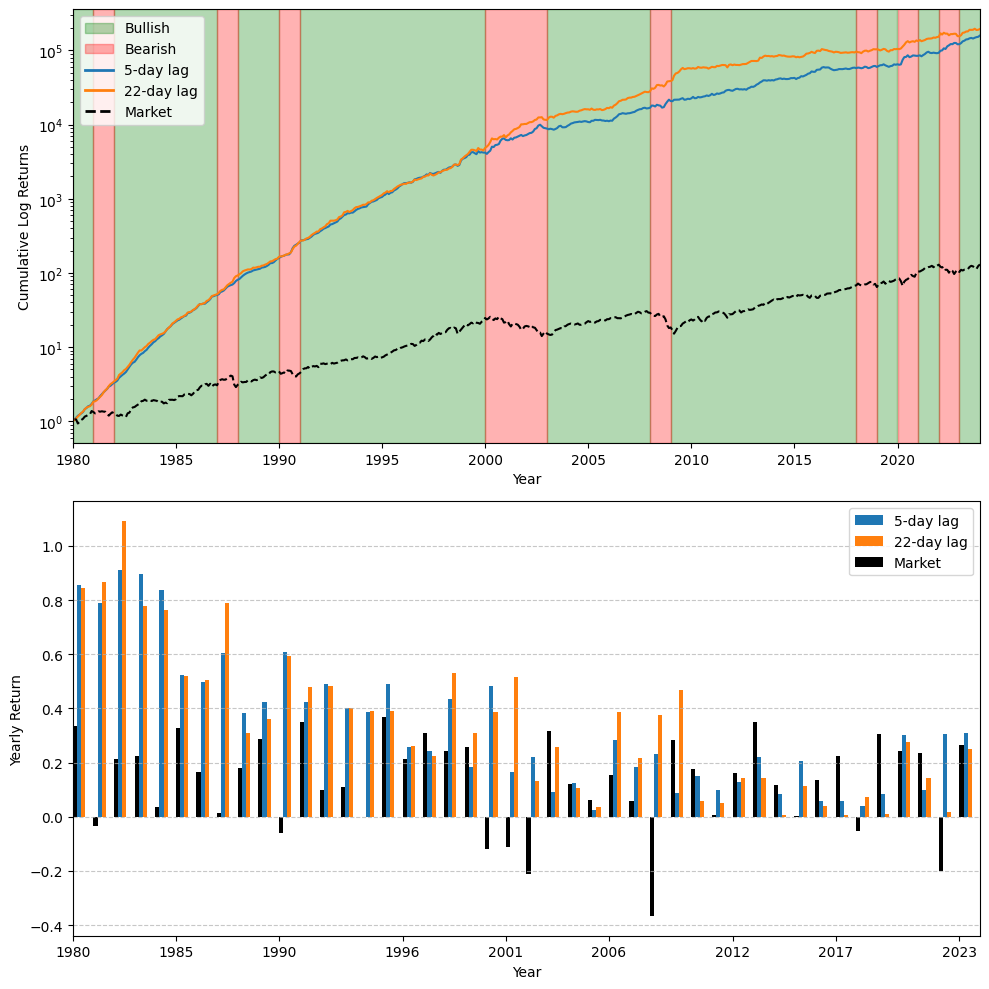

In [292]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

ax0 = axs[0]
ax1 = axs[1]

strat_rets_all = {}

for seq_len in [5, 22]:
    dir_ = f"results/{seq_len}seq_len/SimpleLSTM/49industries/value/5epochs/max-min_LS"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, strat_rets, mkt_rets = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
    
    strat_rets_all[seq_len] = strat_rets

    ax0.plot(cum_rets, label=f"{seq_len}-day lag")

bullish_patch = mpatches.Patch(color='green', alpha=0.3, label='Bullish')
bearish_patch = mpatches.Patch(color='red', alpha=0.3, label='Bearish')

for status, year_range in RANGES.items():
    color = "green" if status == "bullish" else "red"
    for start, end in year_range:
        start_t = pd.to_datetime(f"{start}0101", format="%Y%m%d")
        end_t = pd.to_datetime(f"{end}1231", format="%Y%m%d")
        ax0.axvspan(start_t, end_t, color=color, alpha=0.3)

ax0.plot(mkt_cum_rets, label='Market', color='black', linestyle='--')
ax0.set_yscale('log')
ax0.set_xlabel('Year')
ax0.set_ylabel('Cumulative Log Returns')
# ax0.legend(handles=[bullish_patch, bearish_patch] + plt.gca().get_legend_handles_labels()[0], loc='upper left')
ax0.legend(handles=[bullish_patch, bearish_patch, 
                    plt.Line2D([0], [0], color='C0', lw=2, label='5-day lag'), 
                    plt.Line2D([0], [0], color='C1', lw=2, label='22-day lag'), 
                    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Market')])

# ax0.set_title("Number of Industries Comparison on Best Configuration")
ax0.set_xlim(pd.to_datetime("1980-01-01"), pd.to_datetime("2024-01-01"))

barwidth = 0.2

mkt_ret_vec_monthly = mkt_rets.copy()
mkt_ret_vec_monthly.index = pd.to_datetime(mkt_ret_vec_monthly.index, format="%Y%m%d")
mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)

x = np.arange(len(mkt_ret_vec_monthly.index))

i = 1
for seq_len, strat_rets in strat_rets_all.items():
    strat_ret_vec_monthly = strat_rets.copy()
    strat_ret_vec_monthly.index = pd.to_datetime(strat_ret_vec_monthly.index, format="%Y%m%d")
    strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
    
    ax1.bar(x + barwidth/2 + i * (barwidth), strat_ret_vec_monthly['daily_ret'], label=f"{seq_len}-day lag", width=barwidth)

    i += 1
    
ax1.bar(x + barwidth/2, mkt_ret_vec_monthly.values, label="Market", width=barwidth, color='black')

ax1.set_xlabel("Year")
ax1.set_ylabel("Yearly Return")
ax1.legend(loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

num_ticks = len(ax0.get_xticks()) - 1
tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
tick_labels = strat_ret_vec_monthly.index[tick_positions].strftime('%Y')

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)
ax1.set_xlim(0, len(x))

plt.tight_layout()
plt.savefig("2024_plot4_seq_len_comparison.png")
plt.show()

### Plot 5 - Best Model vs Portfolio Strats

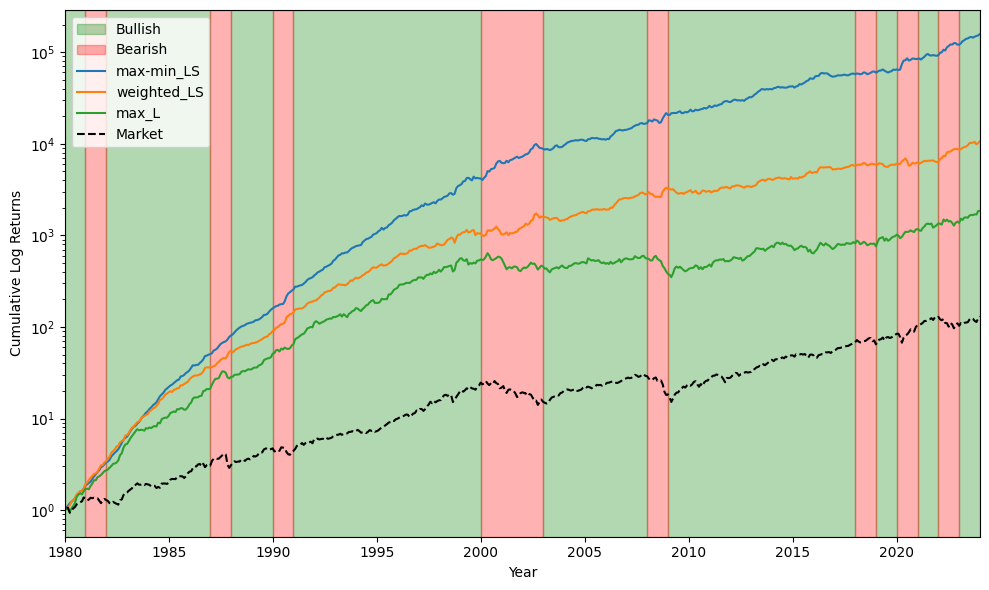

In [293]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

ax0 = axs
# ax1 = axs[1]

strat_rets_all = {}

for port_strat in ["max-min_LS", "weighted_LS", "max_L"]:
    dir_ = f"results/5seq_len/SimpleLSTM/49industries/value/5epochs/{port_strat}"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, strat_rets, mkt_rets = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
    
    strat_rets_all[port_strat] = strat_rets
    
    _, _, _, cum_rets, mkt_cum_rets, _, _ = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)

    ax0.plot(cum_rets, label=f"{port_strat}")

bullish_patch = mpatches.Patch(color='green', alpha=0.3, label='Bullish')
bearish_patch = mpatches.Patch(color='red', alpha=0.3, label='Bearish')

for status, year_range in RANGES.items():
    color = "green" if status == "bullish" else "red"
    for start, end in year_range:
        start_t = pd.to_datetime(f"{start}0101", format="%Y%m%d")
        end_t = pd.to_datetime(f"{end}1231", format="%Y%m%d")
        ax0.axvspan(start_t, end_t, color=color, alpha=0.3)

ax0.plot(mkt_cum_rets, label='Market', color='black', linestyle='--')
ax0.set_yscale('log')
ax0.set_xlabel('Year')
ax0.set_ylabel('Cumulative Log Returns')
ax0.legend(handles=[bullish_patch, bearish_patch] + plt.gca().get_legend_handles_labels()[0], loc='upper left')
# ax0.legend(handles=[bullish_patch, bearish_patch, 
#                     plt.Line2D([0], [0], color='C0', lw=2, label='max-min_LS'), 
#                     plt.Line2D([0], [0], color='C1', lw=2, label='weighted_LS'), 
#                     plt.Line2D([0], [0], color='C2', lw=2, label='max_L'),
#                     plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Market')])
# ax0.set_title("Number of Industries Comparison on Best Configuration")
ax0.set_xlim(pd.to_datetime("1980-01-01"), pd.to_datetime("2024-01-01"))

# barwidth = 0.2
# num_bars = 4

# mkt_ret_vec_monthly = mkt_rets.copy()
# mkt_ret_vec_monthly.index = pd.to_datetime(mkt_ret_vec_monthly.index, format="%Y%m%d")
# mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)

# x = np.arange(len(mkt_ret_vec_monthly.index))

# i = 1
# for port_style, strat_rets in strat_rets_all.items():
#     strat_ret_vec_monthly = strat_rets.copy()
#     strat_ret_vec_monthly.index = pd.to_datetime(strat_ret_vec_monthly.index, format="%Y%m%d")
#     strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
    
#     ax1.bar(x + barwidth/2 + i * (barwidth), strat_ret_vec_monthly['daily_ret'], label=f"{port_style}", width=barwidth)

#     i += 1
    
# ax1.bar(x + barwidth/2, mkt_ret_vec_monthly.values, label="Market", width=barwidth, color='black')

# ax1.set_xlabel("Year")
# ax1.set_ylabel("Yearly Return")
# ax1.legend(loc='upper right')
# ax1.grid(axis='y', linestyle='--', alpha=0.7)

# num_ticks = len(ax0.get_xticks()) - 1
# tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
# tick_labels = strat_ret_vec_monthly.index[tick_positions].strftime('%Y')

# ax1.set_xticks(tick_positions)
# ax1.set_xticklabels(tick_labels, rotation=90)
# ax1.set_xlim(0, len(x))

plt.tight_layout()
plt.savefig("2024_plot5_portfolio_strategy_comparison.png")
plt.show()

### Plot 6 - Best Model vs Equal Weighted

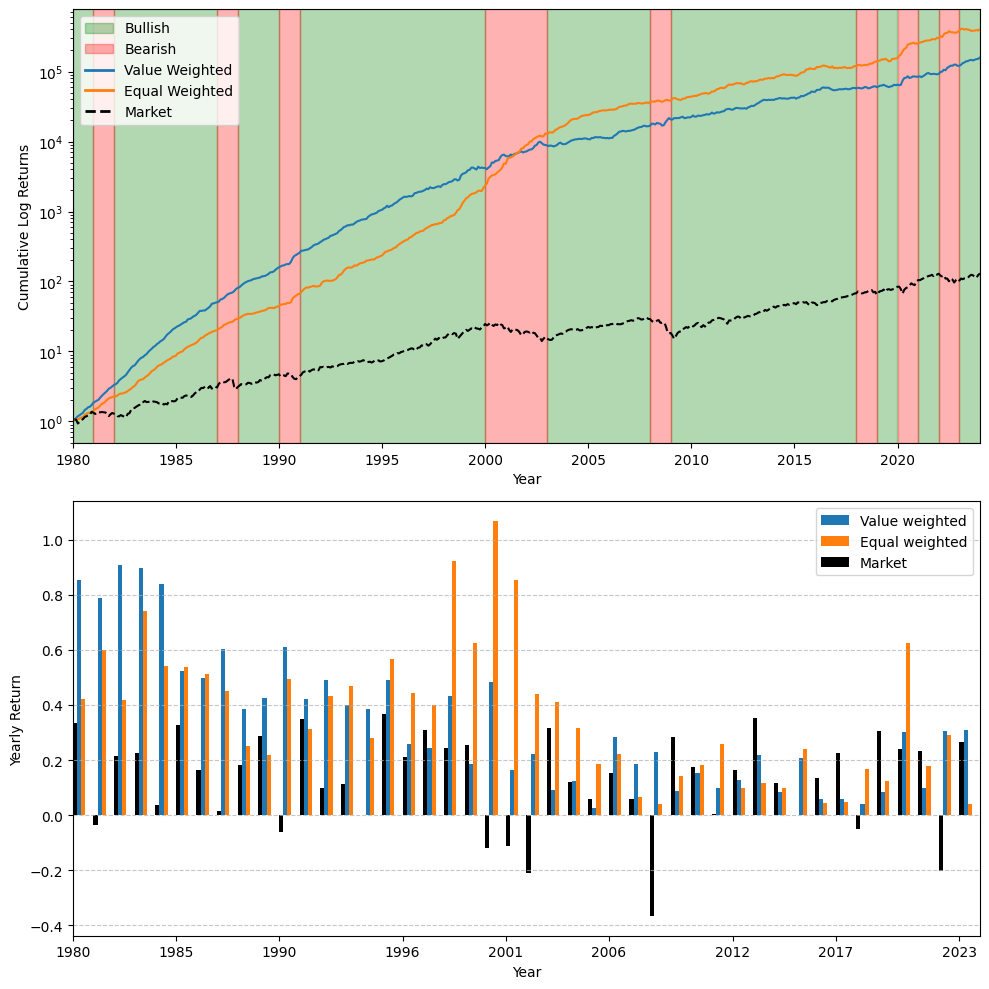

In [294]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

ax0 = axs[0]
ax1 = axs[1]

strat_rets_all = {}

for weighing in ["value", "equal"]:
    dir_ = f"results/5seq_len/SimpleLSTM/49industries/{weighing}/5epochs/max-min_LS"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, strat_rets, mkt_rets = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
    
    strat_rets_all[weighing] = strat_rets
    
    _, _, _, cum_rets, mkt_cum_rets, _, _ = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)

    ax0.plot(cum_rets, label=f"{weighing} weighted".capitalize())

bullish_patch = mpatches.Patch(color='green', alpha=0.3, label='Bullish')
bearish_patch = mpatches.Patch(color='red', alpha=0.3, label='Bearish')

for status, year_range in RANGES.items():
    color = "green" if status == "bullish" else "red"
    for start, end in year_range:
        start_t = pd.to_datetime(f"{start}0101", format="%Y%m%d")
        end_t = pd.to_datetime(f"{end}1231", format="%Y%m%d")
        ax0.axvspan(start_t, end_t, color=color, alpha=0.3)

ax0.plot(mkt_cum_rets, label='Market', color='black', linestyle='--')
ax0.set_yscale('log')
ax0.set_xlabel('Year')
ax0.set_ylabel('Cumulative Log Returns')
# ax0.legend(handles=[bullish_patch, bearish_patch] + plt.gca().get_legend_handles_labels()[0], loc='upper left')
ax0.legend(handles=[bullish_patch, bearish_patch, 
                    plt.Line2D([0], [0], color='C0', lw=2, label='Value Weighted'), 
                    plt.Line2D([0], [0], color='C1', lw=2, label='Equal Weighted'), 
                    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Market')])
# ax0.set_title("Number of Industries Comparison on Best Configuration")
ax0.set_xlim(pd.to_datetime("1980-01-01"), pd.to_datetime("2024-01-01"))

barwidth = 0.2
num_bars = 3

mkt_ret_vec_monthly = mkt_rets.copy()
mkt_ret_vec_monthly.index = pd.to_datetime(mkt_ret_vec_monthly.index, format="%Y%m%d")
mkt_ret_vec_monthly = mkt_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)

x = np.arange(len(mkt_ret_vec_monthly.index))

i = 1
for weighing, strat_rets in strat_rets_all.items():
    strat_ret_vec_monthly = strat_rets.copy()
    strat_ret_vec_monthly.index = pd.to_datetime(strat_ret_vec_monthly.index, format="%Y%m%d")
    strat_ret_vec_monthly = strat_ret_vec_monthly.resample('Y').apply(lambda x: (x/100 + 1).prod() - 1)
    
    ax1.bar(x + barwidth/2 + i * (barwidth), strat_ret_vec_monthly['daily_ret'], label=f"{weighing} Weighted".capitalize(), width=barwidth)

    i += 1
    
ax1.bar(x + barwidth/2, mkt_ret_vec_monthly.values, label="Market", width=barwidth, color='black')

ax1.set_xlabel("Year")
ax1.set_ylabel("Yearly Return")
ax1.legend(loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

num_ticks = len(ax0.get_xticks()) - 1
tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
tick_labels = strat_ret_vec_monthly.index[tick_positions].strftime('%Y')

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)
ax1.set_xlim(0, len(x))

plt.tight_layout()
plt.savefig("2024_plot6_portfolio_weighting_comparison.png")
plt.show()

## Tables

### TABLE 0 - Best Model on CAPM, FF3, FF6

In [295]:
table = pd.DataFrame(columns=['Model', 'Alpha', 'Alpha (Annualized)', 'Beta', 'Sharpe Ratio'])
table.set_index('Model', inplace=True)

round_to = 3

# total_analysis, bullish_analysis, bearish_analysis, total_cum_rets_monthly, total_mkt_cum_rets_monthly, total_rets, total_mkt_rets

for model in ['CAPM', 'FF3', 'FF6']:
    total_analysis, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], 1980, 2024, print_summary=False, benchmark_type=model)
    
    table.loc[model] = [
        str(round(total_analysis['alpha'], round_to)) + ('*' if total_analysis['alpha_p'] < 0.5 else ''), 
        round(total_analysis['alpha_annual'], round_to), 
        round(total_analysis['beta'], round_to),
        round(total_analysis['sharpe'], round_to)
    ]

table

,Alpha,Alpha (Annualized),Beta,Sharpe Ratio
Model,,,,
CAPM,0.094*,28.180,0.007,0.649
FF3,0.094*,27.998,0.009,0.649
FF6,0.092*,27.475,0.021,0.649


### TABLE 1 - Best Model vs. Other Models on FF6 (Time Periods)

In [296]:
table = pd.DataFrame(columns=['Model Type', 'Alpha', 'Alpha (Annualized)', 'Beta', 'Sharpe Ratio'])
table.set_index('Model Type', inplace=True)

ANALYZE_TIMERANGES = [
    (1980, 1995),
    (1996, 2010),
    (2011, 2024),
]

total_lstm_0, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
total_lstm_1, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
total_lstm_2, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)

totaL_ffnn_0, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_ffnn_dir], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
totaL_ffnn_1, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_ffnn_dir], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
totaL_ffnn_2, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_ffnn_dir], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)

total_xgb_0, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_xgb_dir], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
total_xgb_1, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_xgb_dir], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
total_xgb_2, _, _, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_xgb_dir], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)

round_to = 2

def get_alpha(analysis):
    return str(round(analysis['alpha'], round_to)) + ('*' if analysis['alpha_p'] < 0.5 else '')

lstm_row = [
    f"({get_alpha(total_lstm_0)}, {get_alpha(total_lstm_1)}, {get_alpha(total_lstm_2)})",
    f"({round(total_lstm_0['alpha_annual'], round_to)}, {round(total_lstm_1['alpha_annual'], round_to)}, {round(total_lstm_2['alpha_annual'], round_to)})",
    f"({round(total_lstm_0['beta'], round_to)}, {round(total_lstm_1['beta'], round_to)}, {round(total_lstm_2['beta'], round_to)})",
    f"({round(total_lstm_0['sharpe'], round_to)}, {round(total_lstm_1['sharpe'], round_to)}, {round(total_lstm_2['sharpe'], round_to)})",
]

ffnn_row = [
    f"({get_alpha(totaL_ffnn_0)}, {get_alpha(totaL_ffnn_1)}, {get_alpha(totaL_ffnn_2)})",
    f"({round(totaL_ffnn_0['alpha_annual'], round_to)}, {round(totaL_ffnn_1['alpha_annual'], round_to)}, {round(totaL_ffnn_2['alpha_annual'], round_to)})",
    f"({round(totaL_ffnn_0['beta'], round_to)}, {round(totaL_ffnn_1['beta'], round_to)}, {round(totaL_ffnn_2['beta'], round_to)})",
    f"({round(totaL_ffnn_0['sharpe'], round_to)}, {round(totaL_ffnn_1['sharpe'], round_to)}, {round(totaL_ffnn_2['sharpe'], round_to)})",
]

xgb_row = [
    f"({get_alpha(total_xgb_0)}, {get_alpha(total_xgb_1)}, {get_alpha(total_xgb_2)})",
    f"({round(total_xgb_0['alpha_annual'], round_to)}, {round(total_xgb_1['alpha_annual'], round_to)}, {round(total_xgb_2['alpha_annual'], round_to)})",
    f"({round(total_xgb_0['beta'], round_to)}, {round(total_xgb_1['beta'], round_to)}, {round(total_xgb_2['beta'], round_to)})",
    f"({round(total_xgb_0['sharpe'], round_to)}, {round(total_xgb_1['sharpe'], round_to)}, {round(total_xgb_2['sharpe'], round_to)})",

]


table.loc['LSTM'] = lstm_row
table.loc['FFNN'] = ffnn_row
table.loc['XGBRegressor'] = xgb_row
table

# (1980-1995, 1996-2010, 2011-2024)

,Alpha,Alpha (Annualized),Beta,Sharpe Ratio
Model Type,,,,
LSTM,"(0.16*, 0.06*, 0.05*)","(51.57, 17.43, 14.69)","(0.01, 0.03, 0.03)","(1.49, 0.4, 0.41)"
FFNN,"(0.07*, 0.01, 0.01*)","(20.7, 1.6, 3.31)","(-0.04, 0.01, -0.08)","(0.7, 0.05, 0.08)"
XGBRegressor,"(0.07*, 0.02*, 0.01*)","(21.38, 4.49, 3.23)","(0.05, 0.01, 0.03)","(0.8, 0.12, 0.14)"


### TABLE 2 - Best Model on FF6 (Bullish, Bearish, Total)

In [297]:
table = pd.DataFrame(columns=['Market Movement', 'Alpha', 'Alpha (Annualized)', 'Beta', 'Sharpe Ratio'])
table.set_index('Market Movement', inplace=True)

ANALYZE_TIMERANGES = [
    (1980, 1995),
    (1996, 2010),
    (2011, 2024),
]

total_0, bullish_0, bearish_0, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
total_1, bullish_1, bearish_1, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
total_2, bullish_2, bearish_2, _, _, _, _ = analyze_yearrange(strat_ret_vecs[H_lstm_dir], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)

round_to = 2

def get_alpha(analysis):
    return str(round(analysis['alpha'], round_to)) + ('*' if analysis['alpha_p'] < 0.5 else '')

total_row = [
    f"({get_alpha(total_0)}, {get_alpha(total_1)}, {get_alpha(total_2)})",
    f"({round(total_0['alpha_annual'], round_to)}, {round(total_1['alpha_annual'], round_to)}, {round(total_2['alpha_annual'], round_to)}",
    f"({round(total_0['beta'], round_to)}, {round(total_1['beta'], round_to)}, {round(total_2['beta'], round_to)})",
    f"({round(total_0['sharpe'], round_to)}, {round(total_1['sharpe'], round_to)}, {round(total_2['sharpe'], round_to)})",
]

bullish_row = [
    f"({get_alpha(bullish_0)}, {get_alpha(bullish_1)}, {get_alpha(bullish_2)})",
    f"({round(bullish_0['alpha_annual'], round_to)}, {round(bullish_1['alpha_annual'], round_to)}, {round(bullish_2['alpha_annual'], round_to)}",
    f"({round(bullish_0['beta'], round_to)}, {round(bullish_1['beta'], round_to)}, {round(bullish_2['beta'], round_to)})",
    f"({round(bullish_0['sharpe'], round_to)}, {round(bullish_1['sharpe'], round_to)}, {round(bullish_2['sharpe'], round_to)})",
]

bearish_row = [
    f"({get_alpha(bearish_0)}, {get_alpha(bearish_1)}, {get_alpha(bearish_2)})",
    f"({round(bearish_0['alpha_annual'], round_to)}, {round(bearish_1['alpha_annual'], round_to)}, {round(bearish_2['alpha_annual'], round_to)}",
    f"({round(bearish_0['beta'], round_to)}, {round(bearish_1['beta'], round_to)}, {round(bearish_2['beta'], round_to)})",
    f"({round(bearish_0['sharpe'], round_to)}, {round(bearish_1['sharpe'], round_to)}, {round(bearish_2['sharpe'], round_to)})",
]

table.loc['Total'] = total_row
table.loc['Bullish'] = bullish_row
table.loc['Bearish'] = bearish_row
table

# (1980-1995, 1996-2010, 2011-2024)

,Alpha,Alpha (Annualized),Beta,Sharpe Ratio
Market Movement,,,,
Total,"(0.16*, 0.06*, 0.05*)","(51.57, 17.43, 14.69","(0.01, 0.03, 0.03)","(1.49, 0.4, 0.41)"
Bullish,"(0.15*, 0.05*, 0.04*)","(50.32, 15.36, 12.37","(-0.0, 0.03, 0.04)","(1.05, 0.33, 0.38)"
Bearish,"(0.17*, 0.07*, 0.07*)","(58.5, 21.03, 21.07","(0.0, 0.02, 0.03)","(0.45, 0.26, 0.29)"


### Table 3 - Best Model vs Industries

In [298]:
table = pd.DataFrame(columns=['Model Type', 'Alpha', 'Alpha (Annualized)', 'Beta', 'Sharpe Ratio'])
table.set_index('Model Type', inplace=True)

strat_rets_all = {}

comp_vals = [5, 10, 12, 17, 30, 48, 49][::-1]

for val in comp_vals:
    dir_ = f"results/5seq_len/SimpleLSTM/{val}industries/value/5epochs/max-min_LS"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, strat_rets, mkt_rets = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
    
    # make the index a column called "date" in strat_ret_all
    strat_rec_vec = pd.DataFrame(strat_rets)
    strat_rec_vec['date'] = strat_rec_vec.index.strftime('%Y%m%d').astype(int)
    strat_rec_vec = strat_rec_vec.reset_index(drop=True)
    
    strat_rets_all[val] = strat_rec_vec

ANALYZE_TIMERANGES = [
    (1980, 1995),
    (1996, 2010),
    (2011, 2024),
]

def get_alpha(analysis):
    return str(round(analysis['alpha'], round_to)) + ('*' if analysis['alpha_p'] < 0.5 else '')

round_to = 2

for val in comp_vals:
    total0, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
    total1, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
    total2, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)
    
    row = [
        f"({get_alpha(total0)}, {get_alpha(total1)}, {get_alpha(total2)})",
        f"({round(total0['alpha_annual'], round_to)}, {round(total1['alpha_annual'], round_to)}, {round(total2['alpha_annual'], round_to)})",
        f"({round(total0['beta'], round_to)}, {round(total1['beta'], round_to)}, {round(total2['beta'], round_to)})",
        f"({round(total0['sharpe'], round_to)}, {round(total1['sharpe'], round_to)}, {round(total2['sharpe'], round_to)})",
    ]
        
    table.loc[f'{val} Industries'] = row
    
    
table
# (1980-1995, 1996-2010, 2011-2024)

,Alpha,Alpha (Annualized),Beta,Sharpe Ratio
Model Type,,,,
49 Industries,"(0.16*, 0.06*, 0.05*)","(51.57, 17.43, 14.69)","(0.01, 0.03, 0.03)","(1.49, 0.4, 0.41)"
48 Industries,"(0.16*, 0.08*, 0.03*)","(53.09, 23.28, 8.8)","(0.02, 0.02, 0.01)","(1.37, 0.48, 0.24)"
30 Industries,"(0.12*, 0.04*, 0.01*)","(39.05, 10.07, 3.06)","(0.02, -0.02, -0.02)","(1.17, 0.21, 0.07)"
17 Industries,"(0.18*, 0.08*, 0.02*)","(58.77, 21.97, 5.31)","(-0.03, -0.03, -0.02)","(1.29, 0.4, 0.11)"
12 Industries,"(0.19*, 0.03*, 0.0)","(63.97, 8.76, 0.8)","(-0.05, -0.01, -0.04)","(1.43, 0.19, 0.01)"
10 Industries,"(0.24*, -0.0, 0.02*)","(88.93, -0.39, 4.43)","(-0.06, -0.05, -0.04)","(1.36, 0.01, 0.07)"
5 Industries,"(0.1*, 0.0, 0.02*)","(29.82, 1.3, 4.28)","(-0.05, 0.01, -0.03)","(0.75, 0.03, 0.1)"


### Table 4 - Best Model vs Different Seq Len

In [299]:
table = pd.DataFrame(columns=['Model Type', 'Alpha', 'Alpha (Annualized)', 'Beta', 'Sharpe Ratio'])
table.set_index('Model Type', inplace=True)

strat_rets_all = {}

comp_vals = [5, 22]

for val in comp_vals:
    dir_ = f"results/{val}seq_len/SimpleLSTM/49industries/value/5epochs/max-min_LS"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, strat_rets, mkt_rets = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
    
    # make the index a column called "date" in strat_ret_all
    strat_rec_vec = pd.DataFrame(strat_rets)
    strat_rec_vec['date'] = strat_rec_vec.index.strftime('%Y%m%d').astype(int)
    strat_rec_vec = strat_rec_vec.reset_index(drop=True)
    
    strat_rets_all[val] = strat_rec_vec

ANALYZE_TIMERANGES = [
    (1980, 1995),
    (1996, 2010),
    (2011, 2024),
]

def get_alpha(analysis):
    return str(round(analysis['alpha'], round_to)) + ('*' if analysis['alpha_p'] < 0.5 else '')

round_to = 2

for val in comp_vals:
    total0, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
    total1, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
    total2, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)
    
    row = [
        f"({get_alpha(total0)}, {get_alpha(total1)}, {get_alpha(total2)})",
        f"({round(total0['alpha_annual'], round_to)}, {round(total1['alpha_annual'], round_to)}, {round(total2['alpha_annual'], round_to)})",
        f"({round(total0['beta'], round_to)}, {round(total1['beta'], round_to)}, {round(total2['beta'], round_to)})",
        f"({round(total0['sharpe'], round_to)}, {round(total1['sharpe'], round_to)}, {round(total2['sharpe'], round_to)})",
    ]
        
    table.loc[f'{val}-day lag'] = row
    
    
table
# (1980-1995, 1996-2010, 2011-2024)

,Alpha,Alpha (Annualized),Beta,Sharpe Ratio
Model Type,,,,
5-day lag,"(0.16*, 0.06*, 0.05*)","(51.57, 17.43, 14.69)","(0.01, 0.03, 0.03)","(1.49, 0.4, 0.41)"
22-day lag,"(0.16*, 0.09*, 0.03*)","(51.73, 26.99, 8.38)","(-0.0, 0.01, 0.06)","(1.34, 0.55, 0.25)"


### Table 5 - Best Model vs. Other Portfolio Strats

In [300]:
table = pd.DataFrame(columns=['Model Type', 'Alpha', 'Alpha (Annualized)', 'Beta', 'Sharpe Ratio'])
table.set_index('Model Type', inplace=True)

strat_rets_all = {}

comp_vals = ['max-min_LS', 'weighted_LS', 'max_L']

for val in comp_vals:
    dir_ = f"results/5seq_len/SimpleLSTM/49industries/value/5epochs/{val}"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, strat_rets, mkt_rets = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
    
    # make the index a column called "date" in strat_ret_all
    strat_rec_vec = pd.DataFrame(strat_rets)
    strat_rec_vec['date'] = strat_rec_vec.index.strftime('%Y%m%d').astype(int)
    strat_rec_vec = strat_rec_vec.reset_index(drop=True)
    
    strat_rets_all[val] = strat_rec_vec

ANALYZE_TIMERANGES = [
    (1980, 1995),
    (1996, 2010),
    (2011, 2024),
]

def get_alpha(analysis):
    return str(round(analysis['alpha'], round_to)) + ('*' if analysis['alpha_p'] < 0.5 else '')

round_to = 2

for val in comp_vals:
    total0, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
    total1, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
    total2, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)
    
    row = [
        f"({get_alpha(total0)}, {get_alpha(total1)}, {get_alpha(total2)})",
        f"({round(total0['alpha_annual'], round_to)}, {round(total1['alpha_annual'], round_to)}, {round(total2['alpha_annual'], round_to)})",
        f"({round(total0['beta'], round_to)}, {round(total1['beta'], round_to)}, {round(total2['beta'], round_to)})",
        f"({round(total0['sharpe'], round_to)}, {round(total1['sharpe'], round_to)}, {round(total2['sharpe'], round_to)})",
    ]
        
    table.loc[f'{val}'.replace('_L', ' Long').replace('S', '-Short')] = row
    
    
table
# (1980-1995, 1996-2010, 2011-2024)

,Alpha,Alpha (Annualized),Beta,Sharpe Ratio
Model Type,,,,
max-min Long-Short,"(0.16*, 0.06*, 0.05*)","(51.57, 17.43, 14.69)","(0.01, 0.03, 0.03)","(1.49, 0.4, 0.41)"
weighted Long-Short,"(0.13*, 0.03*, 0.03*)","(42.38, 9.44, 9.43)","(-0.05, 0.04, 0.07)","(1.0, 0.2, 0.27)"
max Long,"(0.09*, -0.01*, 0.01)","(28.35, -3.86, 2.11)","(0.68, 0.65, 0.7)","(0.57, 0.03, 0.2)"


### Table 6 - Best Model vs Equal Weighted

In [301]:
table = pd.DataFrame(columns=['Model Type', 'Alpha', 'Alpha (Annualized)', 'Beta', 'Sharpe Ratio'])
table.set_index('Model Type', inplace=True)

strat_rets_all = {}

comp_vals = ['value', 'equal']

for val in comp_vals:
    dir_ = f"results/5seq_len/SimpleLSTM/49industries/{val}/5epochs/max-min_LS"

    strat_ret_vec_path = f"{dir_}/strat_ret_vec.csv"
    strat_ret_vec = pd.read_csv(strat_ret_vec_path)
    strat_ret_vec['daily_ret'] = strat_ret_vec['0']
    strat_ret_vec = strat_ret_vec.drop(columns=['0'])
    
    _, _, _, cum_rets, mkt_cum_rets, strat_rets, mkt_rets = analyze_yearrange(strat_ret_vec, 1980, 2024, print_summary=False)
    
    # make the index a column called "date" in strat_ret_all
    strat_rec_vec = pd.DataFrame(strat_rets)
    strat_rec_vec['date'] = strat_rec_vec.index.strftime('%Y%m%d').astype(int)
    strat_rec_vec = strat_rec_vec.reset_index(drop=True)
    
    strat_rets_all[val] = strat_rec_vec

ANALYZE_TIMERANGES = [
    (1980, 1995),
    (1996, 2010),
    (2011, 2024),
]

def get_alpha(analysis):
    return str(round(analysis['alpha'], round_to)) + ('*' if analysis['alpha_p'] < 0.5 else '')

round_to = 2

for val in comp_vals:
    total0, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[0][0], ANALYZE_TIMERANGES[0][1], print_summary=False)
    total1, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[1][0], ANALYZE_TIMERANGES[1][1], print_summary=False)
    total2, _, _, _, _, _, _ = analyze_yearrange(strat_rets_all[val], ANALYZE_TIMERANGES[2][0], ANALYZE_TIMERANGES[2][1], print_summary=False)
    
    row = [
        f"({get_alpha(total0)}, {get_alpha(total1)}, {get_alpha(total2)})",
        f"({round(total0['alpha_annual'], round_to)}, {round(total1['alpha_annual'], round_to)}, {round(total2['alpha_annual'], round_to)})",
        f"({round(total0['beta'], round_to)}, {round(total1['beta'], round_to)}, {round(total2['beta'], round_to)})",
        f"({round(total0['sharpe'], round_to)}, {round(total1['sharpe'], round_to)}, {round(total2['sharpe'], round_to)})",
    ]
        
    table.loc[f'{val} Weighted'.capitalize()] = row
    
    
table
# (1980-1995, 1996-2010, 2011-2024)

,Alpha,Alpha (Annualized),Beta,Sharpe Ratio
Model Type,,,,
Value weighted,"(0.16*, 0.06*, 0.05*)","(51.57, 17.43, 14.69)","(0.01, 0.03, 0.03)","(1.49, 0.4, 0.41)"
Equal weighted,"(0.12*, 0.13*, 0.06*)","(35.46, 39.2, 17.46)","(0.01, -0.04, -0.01)","(1.08, 0.79, 0.45)"
